# Initial settings

directoryのセットアップ

In [34]:
import os
import glob

cwd = os.getcwd()
user = 'keetane'
project = 'ruxolitinib'
wd = os.path.join(cwd, '1_wd', user, project)
input_dir    = os.path.join(wd, 'input');    os.makedirs(input_dir, exist_ok=True)
results_dir  = os.path.join(wd, 'results');  os.makedirs(results_dir, exist_ok=True)
results_log  = os.path.join(results_dir, 'log');  os.makedirs(results_log, exist_ok=True)
toml_dir     = os.path.join(wd, 'toml');     os.makedirs(toml_dir, exist_ok=True)
toml_path = os.path.join(toml_dir, "sampling.toml")
sampling_log = os.path.join(results_dir, 'log'); os.makedirs(sampling_log, exist_ok=True)
# priors_dir = os.path.join(cwd, 'priors')
# model_list = glob.glob(priors_dir + '/*.prior')[2:-1]   # reinvent, linkinvent, libinventは除外
# model_name = [x.split('/')[-1].split('.')[0][8:] for x in model_list]
# model_name
input_dir

'/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/input'

Mol2Molのモデルの確認とdict化

In [35]:
# mol2mol modelのパスとモデル名のリストからdictを作成
model_path_list = glob.glob(cwd+'/priors/mol2mol*.prior') 
model_name_list = [os.path.basename(path).split('.')[0][8:] for path in model_path_list]  # reinvent, libinvent, linkinventを除外
model_dict = dict(zip(model_name_list, model_path_list))

# pubchem_ecfp4をappend
model_dict['pubchem']=glob.glob(cwd+'/priors/*.prior')[2]
model_dict


{'mmp': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_mmp.prior',
 'high_similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_high_similarity.prior',
 'medium_similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_medium_similarity.prior',
 'similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_similarity.prior',
 'scaffold_generic': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_scaffold_generic.prior',
 'scaffold': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_scaffold.prior',
 'pubchem': '/Users/keetane/Documents/apps/REINVENT4/priors/pubchem_ecfp4_with_count_with_rank_reinvent4_dict_voc.prior'}

input file=ruxolitinibの準備

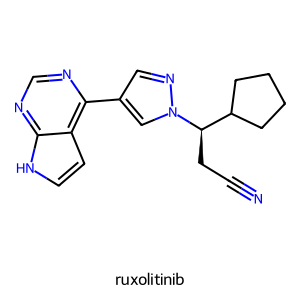

In [ ]:
import pandas as pd
import pubchempy as pcp
from rdkit import Chem
from rdkit.Chem import Draw

# ruxolitinibのSMILESをPubChemから取得
parent = project 
compound = pcp.get_compounds(parent, 'name')
rxt_smiles = compound[0].isomeric_smiles

# rxt_smilesをparent.smiとして保存
with open(f'{input_dir}' + "/parent.smi", "w") as f:
    f.write(rxt_smiles) 

# rxt_smilesを描画
Draw.MolToImage(Chem.MolFromSmiles(rxt_smiles), size=(300, 300), legend=parent)

tomlファイル作成とreinventの実行用関数

In [37]:
import subprocess as sp
def reinvent(model, # input model_dict.keys()
              input_smiles=input_dir+'/parent.smi', # default {input_dir}/parent.smi
                num_smiles=10000,
                  device='mps', 
                    sample_strategy='beamsearch',
                      temperature=1.0):
    if model.split('/')[-1].split('.')[0][:8]=='mol2mol_':
        model_name = model.split('/')[-1].split('.')[0][8:] # mol2mol_の後ろの文字列を取得
    else:
        model_name = model.split('/')[-1].split('.')[0][:13] # ==pubchem_ecfp4
    toml = f"""
run_type = "sampling"
device = "{device}"
json_out_config = "{results_log}_sampling.json"

[parameters]
model_file = "{model}"
output_file = "{results_dir}/{parent}_{model_name}.csv"
num_smiles = "{num_smiles}"
unique_molecules = true
randomize_smiles = true
smiles_file = "{input_smiles}"
sample_strategy = "{sample_strategy}"
temperature = "{temperature}"
"""
    with open(toml_path, "w") as f:
        f.write(toml)
    log_file = os.path.join(sampling_log, "sampling.log")
    cmd = ['reinvent', '-l', log_file, toml_path]
    sp.call(cmd)

reinvent関数のテスト実行

In [38]:
model_dict

{'mmp': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_mmp.prior',
 'high_similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_high_similarity.prior',
 'medium_similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_medium_similarity.prior',
 'similarity': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_similarity.prior',
 'scaffold_generic': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_scaffold_generic.prior',
 'scaffold': '/Users/keetane/Documents/apps/REINVENT4/priors/mol2mol_scaffold.prior',
 'pubchem': '/Users/keetane/Documents/apps/REINVENT4/priors/pubchem_ecfp4_with_count_with_rank_reinvent4_dict_voc.prior'}

In [39]:
model_name = 'medium_similarity'
reinvent(model=model_dict[model_name],
          num_smiles=10000,
          sample_strategy='beamsearch',
        #   input_smiles=os.path.join(input_dir, "parent.smi"),
        #   device='mps',
        #   temperature=1.0
          )
pd.read_csv(os.path.join(results_dir, f"{parent}_{model_name}.csv")).head()

,SMILES,Input_SMILES,Tanimoto,NLL


# Sampling molecules for all models

全モデルについて10000分子を生成し、ファイルを結合

In [ ]:
# 全モデルでreinventを実行
for model in model_dict.values():
    reinvent(model,
              num_smiles=10000,
              sample_strategy='beamsearch',
            #   input_smiles=os.path.join(input_dir, "parent.smi"),
            #   device='mps',
            #   temperature=1.0
              )


python(5758) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6001) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6418) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
python(6780) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.


全てのモデルの結果を結合

In [42]:
glob.glob(results_dir + f"/{parent}_*.csv")

['/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_all_model.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_high_similarity.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_scaffold_generic.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_pubchem_ecfp4.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_mmp.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_scaffold.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_similarity.csv',
 '/Users/keetane/Documents/apps/REINVENT4/1_wd/keetane/ruxolitinib/results/ruxolitinib_medium_similarity.csv']

In [51]:
# 結果の読み込みと結合
# 出力結果のリストを作成
results_list = glob.glob(results_dir + f"/{parent}_*.csv")

# 結合ファイルが存在する場合は除外
all_model = f'{results_dir}/{parent}_all_model.csv'
results_list = [item for item in results_list if item != all_model]

# 出力結果リストからloopでdataframeを取得し結合、保存
df = []
for csv in results_list:
    temp = pd.read_csv(csv, sep=',')
    temp['model'] = csv.split('/')[-1].split('.')[0][len(parent)+1:]
    df.append(temp)
df = pd.concat(df, ignore_index=True)
df.to_csv(f'{results_dir}/{parent}_all_model.csv', index=False)
df[-5:]


,SMILES,Input_SMILES,Tanimoto,NLL,model
49852,CC(C)CS(=O)(=O)NC[C@H](C1CCCC1)n1ncc(-c2ncnc3[...,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,0.471698,12.56,similarity
49853,N#CC[C@H](C1CCCCC1)n1ccc(-c2ncnc3[nH]c(-c4ccc(...,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,0.443478,12.56,similarity
49854,Cc1ccc(S(=O)(=O)n2cc(-c3cnn(C(CC#N)C4CCCC4)c3)...,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,0.466019,12.59,similarity
49855,CS(=O)(=O)NC(=O)CCC(C1CCCC1)n1ccc(-c2ccnc3[nH]...,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,0.385321,12.59,similarity
49856,CS(=O)(=O)NC(=O)CC(C1CCCCC1)n1ncc(-c2ccnc3[nH]...,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,0.390909,12.65,similarity


重複の検出

7677 was duplicated
5254 molecules were unique


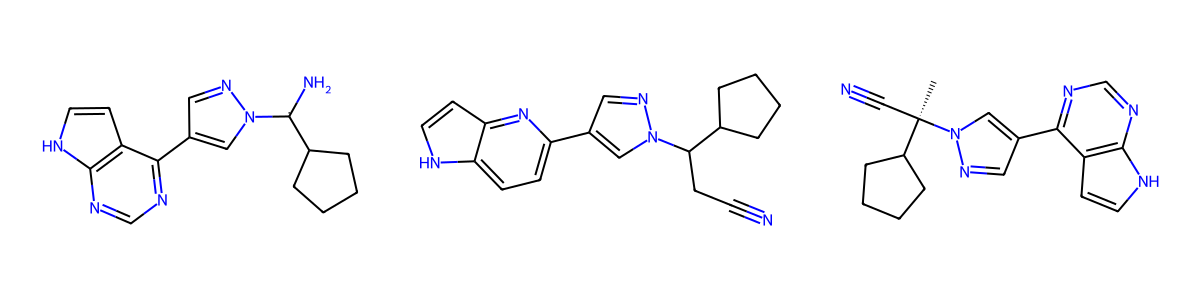

In [75]:
# SMILESの正規化
def duplicant_detector(smiles):
    mol = Chem.MolFromSmiles(smiles)
    canonical_smiles = Chem.MolToSmiles(mol, isomericSmiles=True, canonical=True)
    return canonical_smiles

df['canonical_smiles'] = df.SMILES.map(lambda x : duplicant_detector(x))
# 重複の検出
df_dup = df[df.duplicated(subset='canonical_smiles')]
print(str(str(len(df_dup)) + ' was duplicated'))
print(str(len(df_dup.canonical_smiles.unique())) + ' molecules were unique')
Draw.MolsToGridImage(
    [mol for mol in df_dup.SMILES.map(lambda x : Chem.MolFromSmiles(x)).sample(3)],
    subImgSize=(400,300)
)

descriptorの計算

In [91]:
import pandas as pd
from rdkit import Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import Lipinski
from rdkit.Chem import AllChem 
from rdkit.Chem import rdMolDescriptors 

def calculate_rdkit_descriptors(df, smiles_column='SMILES'):
    descriptor_functions = {
        'MW': Descriptors.MolWt,
        'LogP': Descriptors.MolLogP,
        'TPSA': Descriptors.TPSA,
        'HBA': Lipinski.NumHAcceptors,
        'HBD': Lipinski.NumHDonors,
        'Rotatable_Bonds': Descriptors.NumRotatableBonds,
        'Amide_Count': AllChem.CalcNumAmideBonds,
        'Ring_Count': rdMolDescriptors.CalcNumRings,
        'Aromatic_Ring_Count': rdMolDescriptors.CalcNumAromaticRings,
        'Fraction_CSP3': rdMolDescriptors.CalcFractionCSP3,
    }

    def smiles_to_mol(smiles):
        if pd.isna(smiles):
            return None
        try:
            mol = Chem.MolFromSmiles(str(smiles))
            # AssignStereoChemistry はこのエラーのために呼び出さない
            # Chem.AssignStereoChemistry(mol, cleanIt=True, force=True) 
            return mol
        except Exception as e:
            print(f"SMILESパース例外: '{smiles}' - {e}")
            return None

    def count_chiral_centers_fallback(mol):
        """
        AssignStereoChemistryが使えない場合のキラル中心数フォールバック関数。
        SMILESから直接エンコードされたキラル中心のみをカウントする傾向があります。
        """
        if mol is None:
            return 0
        
        num_chiral = 0
        for atom in mol.GetAtoms():
            # アトムに立体情報が設定されているか確認
            # CHI_UNSPECIFIED (0) 以外であれば、立体中心として認識されている
            if atom.GetChiralTag() != Chem.rdchem.ChiralType.CHI_UNSPECIFIED:
                # この原子が四面体中心として妥当か確認 (結合数が4など)
                # より厳密なチェックが必要な場合もあるが、ここではシンプルに
                if atom.GetDegree() >= 3: 
                    num_chiral += 1
        return num_chiral

    df['mol_object'] = df[smiles_column].apply(smiles_to_mol)

    for desc_name, desc_func in descriptor_functions.items():
        df[desc_name] = df['mol_object'].apply(
            lambda mol: desc_func(mol) if mol is not None else None
        )
    
    # キラリティの有無を判定するディスクリプタを追加
    # フォールバック関数を使用
    df['NumChiralCenters'] = df['mol_object'].apply(
        lambda mol: count_chiral_centers_fallback(mol) if mol is not None else 0
    )
    # df['IsChiral'] = df['NumChiralCenters'].apply(lambda num: num > 0) # この行を削除
    
    df.drop(columns=['mol_object'], inplace=True) 
    
    return df


# csvを読み込み
csv_path = f"{results_dir}/{parent}_all_model.csv"
df = pd.read_csv(csv_path)

#　計算結果を保存
df = calculate_rdkit_descriptors(df)
df.to_csv(f'{results_dir}/{parent}_all_desc.csv', index=False)
df.head()

,SMILES,Input_SMILES,Tanimoto,NLL,model,MW,LogP,TPSA,HBA,HBD,Rotatable_Bonds,Amide_Count,Ring_Count,Aromatic_Ring_Count,Fraction_CSP3,NumChiralCenters
0,N#CCC(C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,0.957746,1.54,high_similarity,320.400,3.85648,83.18,5,1,4,0,4,3,0.444444,0
1,N#CC[C@@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,0.957746,2.69,high_similarity,320.400,3.85648,83.18,5,1,4,0,4,3,0.444444,1
2,N#CCC(C1CCOCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,0.805195,2.93,high_similarity,322.372,2.70278,92.41,6,1,4,0,4,3,0.411765,0
3,N#CCC(C1CCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,0.913043,3.01,high_similarity,292.346,3.07628,83.18,5,1,4,0,4,3,0.375000,0
4,N#CC[C@H](C1CCCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,N#CC[C@H](C1CCCC1)n1cc(-c2ncnc3[nH]ccc23)cn1,0.957746,3.12,high_similarity,320.400,3.85648,83.18,5,1,4,0,4,3,0.444444,1


In [24]:
df.model.unique()

array(['high_similarity', 'scaffold_generic', 'pubchem_ecfp4', 'mmp',
       'scaffold', 'similarity'], dtype=object)

# Visualizaion of Chemical Space

各Descriptorについてviolin plot


--- バイオリンプロット（各パラメータについてモデル別） ---


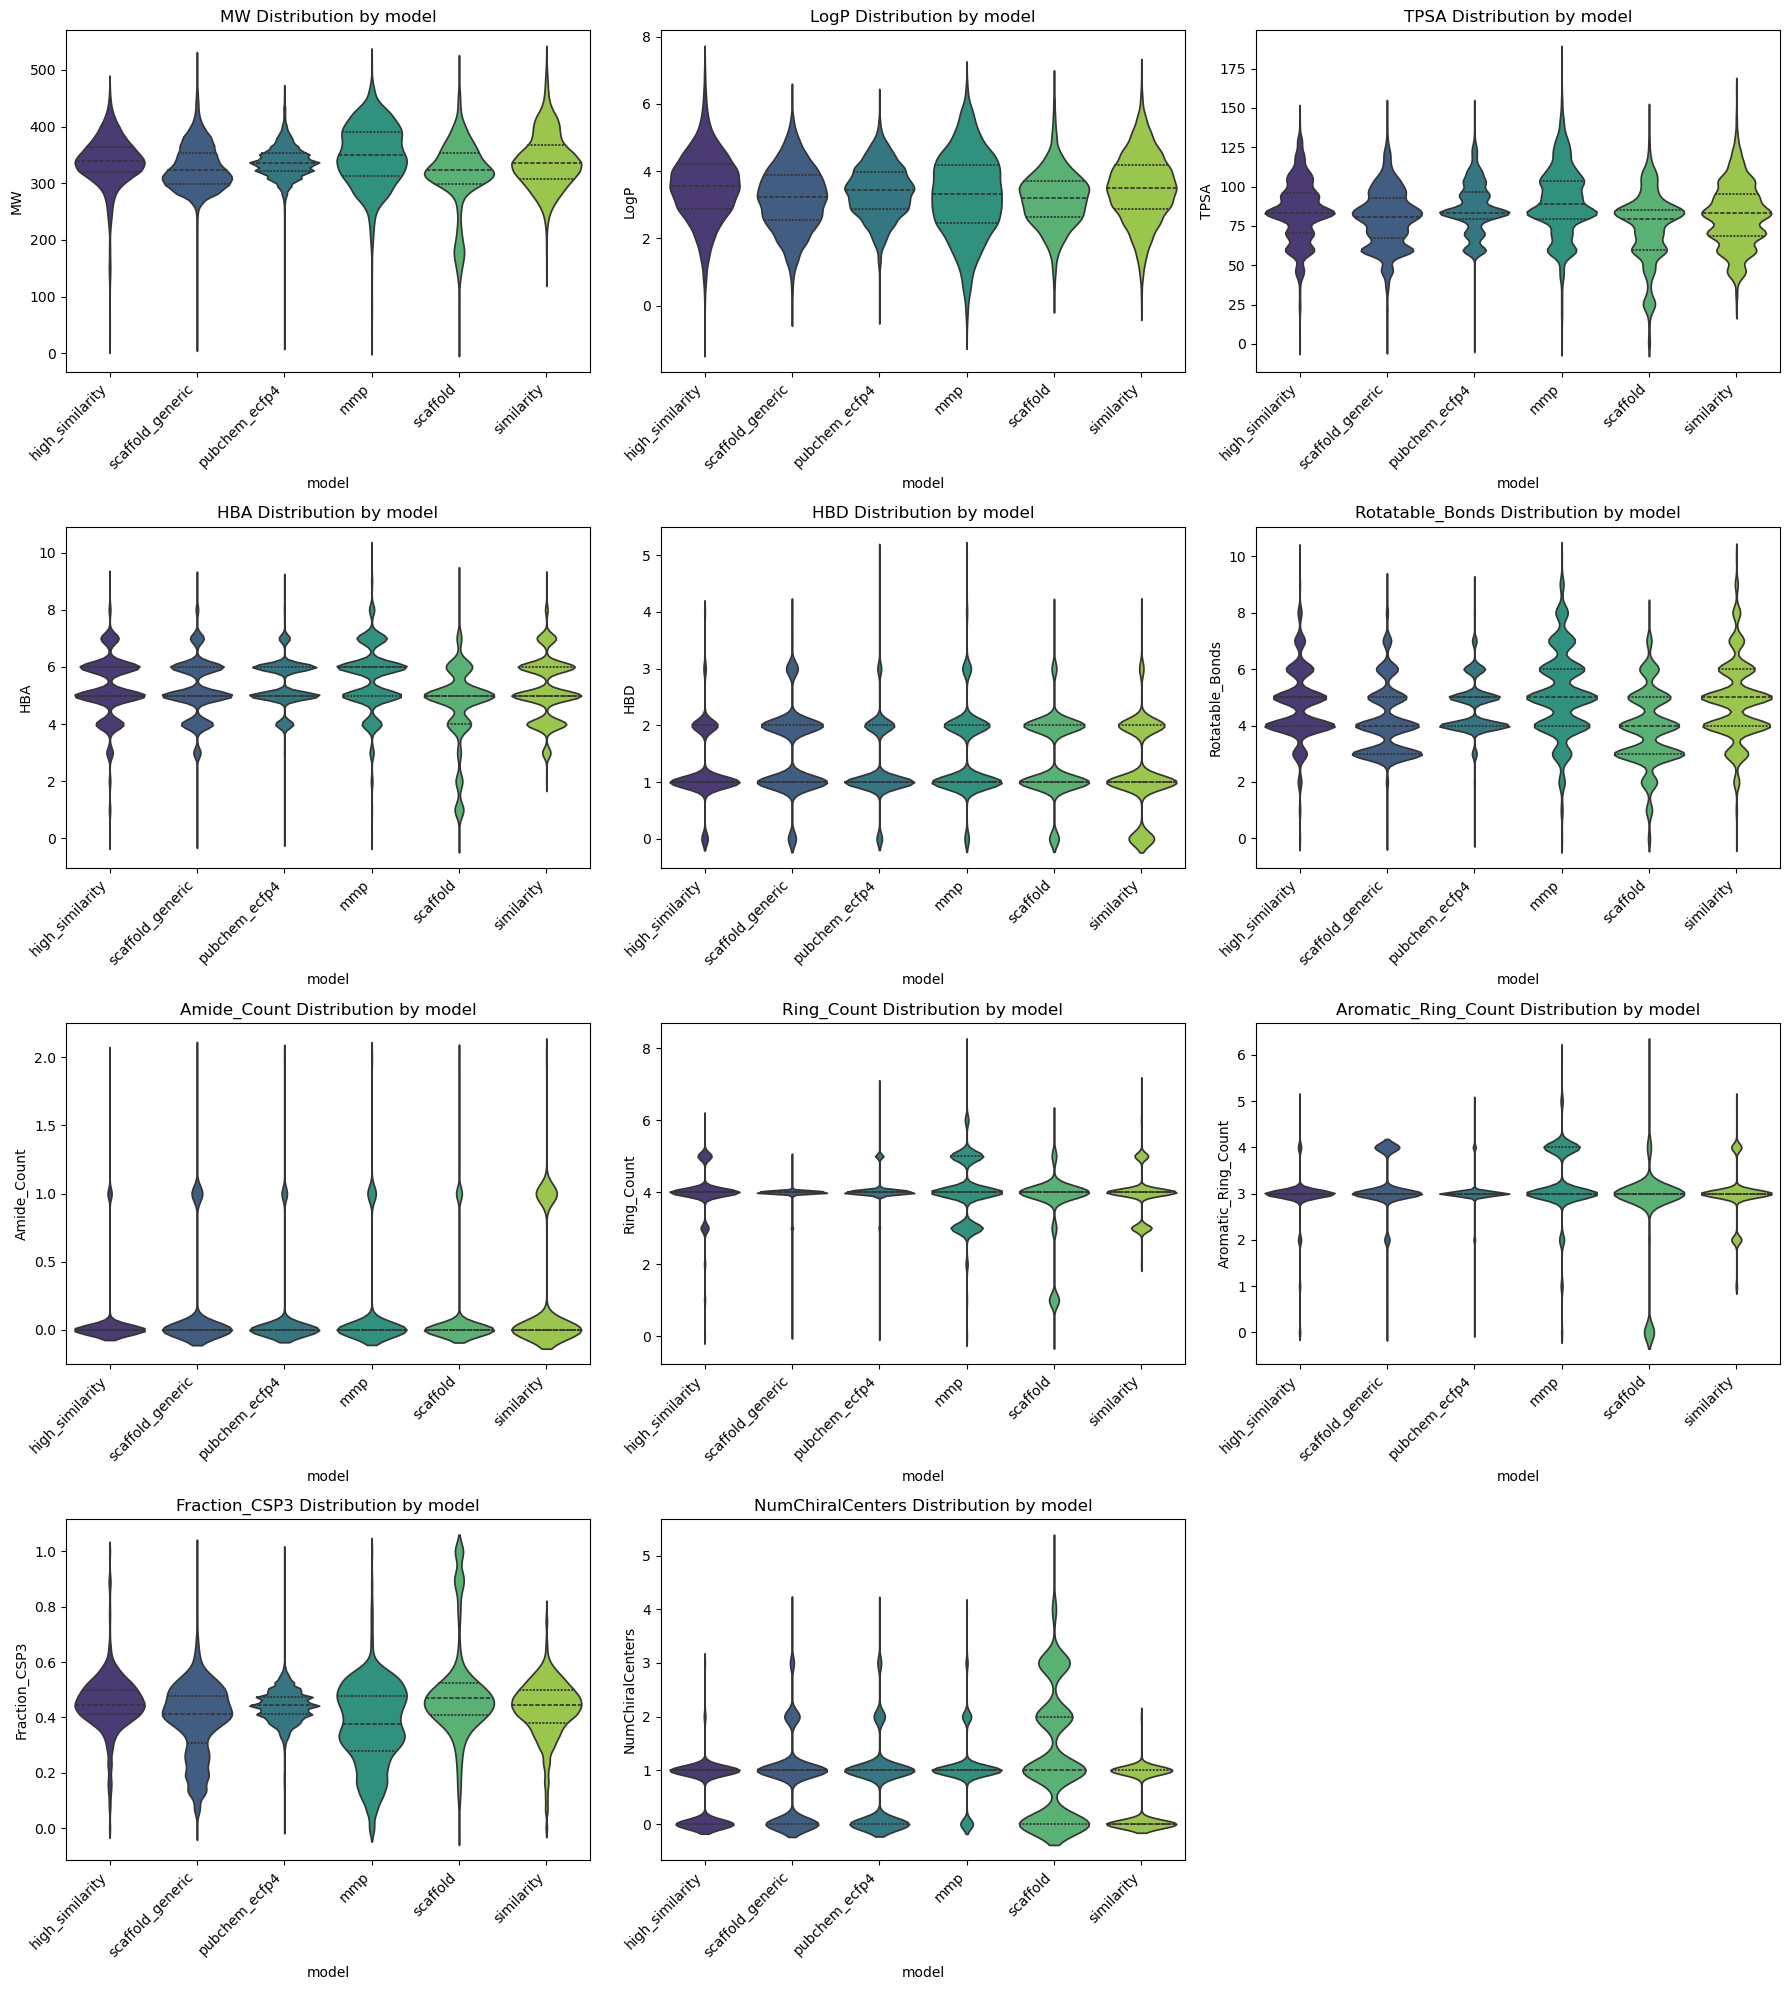

In [93]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import os
import warnings # warningsモジュールをインポート

# FutureWarningを無視する設定
warnings.filterwarnings("ignore", category=FutureWarning)

def visualize_chemical_space_distributions(df, model_column='model'):
    descriptors_to_plot = [
        'MW', 'LogP', 'TPSA', 'HBA', 'HBD',
        'Rotatable_Bonds', 'Amide_Count', 'Ring_Count',
        'Aromatic_Ring_Count', 'Fraction_CSP3', 'NumChiralCenters'
    ]

    print("\n--- バイオリンプロット（各パラメータについてモデル別） ---")
    num_plots = len(descriptors_to_plot)
    num_cols = 3
    num_rows = (num_plots + num_cols - 1) // num_cols

    if num_plots == 0:
        print("警告: プロットする記述子が指定されていません。")
        return

    plt.figure(figsize=(num_cols * 6, num_rows * 5))

    for i, desc in enumerate(descriptors_to_plot):
        plt.subplot(num_rows, num_cols, i + 1)
        if desc not in df.columns:
            print(f"警告: カラム '{desc}' がDataFrameに存在しません。スキップします。")
            continue
        
        if df[desc].isnull().all():
            print(f"警告: カラム '{desc}' に有効なデータがありません（全てNaN）。スキップします。")
            continue

        sns.violinplot(data=df, x=model_column, y=desc, palette="viridis", inner="quartile")
        plt.title(f'{desc} Distribution by {model_column}')
        plt.xlabel(model_column)
        plt.ylabel(desc)
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

df = pd.read_csv(f'{results_dir}/{parent}_all_desc.csv')
visualize_chemical_space_distributions(df)


Tanimoto係数とNLLをscatter plot

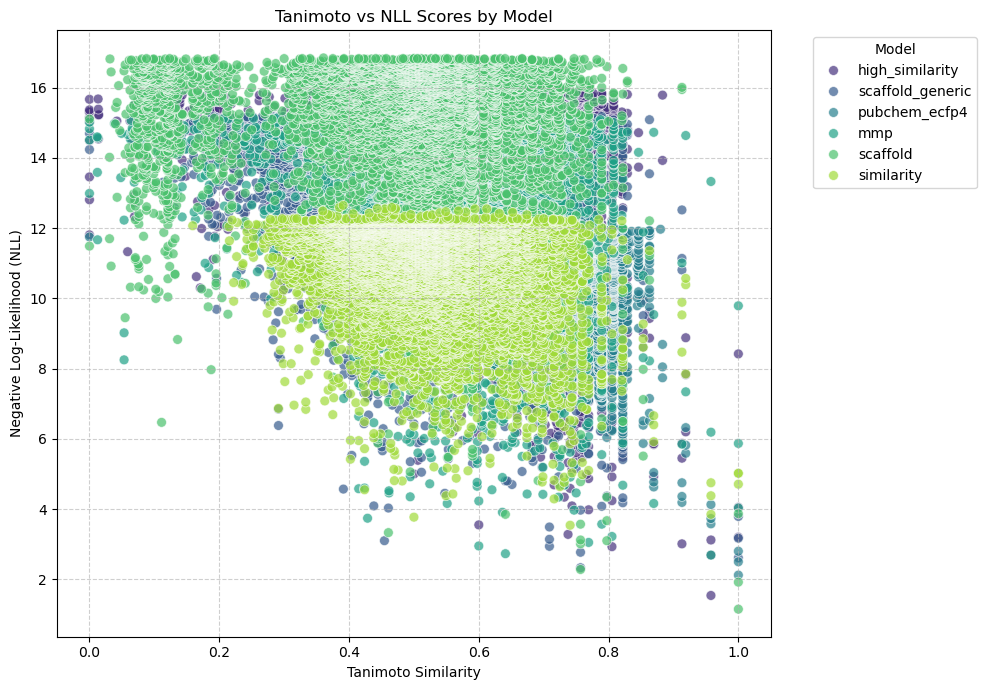

In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def create_tanimoto_nll_scatterplot(df):
    # 必要なカラムが存在するか確認
    required_columns = ['Tanimoto', 'NLL', 'model']
    for col in required_columns:
        if col not in df.columns:
            print(f"エラー: 必須カラム '{col}' がDataFrameに存在しません。")
            return

    plt.figure(figsize=(10, 7)) # プロットのサイズを設定

    # 散布図の作成
    # hue='model' で 'model' カラムの値に基づいて色分けされます。
    sns.scatterplot(data=df, x='Tanimoto', y='NLL', hue='model', palette='viridis', s=50, alpha=0.7)

    plt.title('Tanimoto vs NLL Scores by Model') # タイトル
    plt.xlabel('Tanimoto Similarity') # x軸ラベル
    plt.ylabel('Negative Log-Likelihood (NLL)') # y軸ラベル
    plt.grid(True, linestyle='--', alpha=0.6) # グリッドを追加
    plt.legend(title='Model', bbox_to_anchor=(1.05, 1), loc='upper left') # 凡例をプロットの外に配置
    plt.tight_layout() # レイアウトを調整してラベルが重ならないようにする
    plt.show()
create_tanimoto_nll_scatterplot(df)

トレリスで散布図を表示


--- トレリスプロット（Tanimoto vs NLL スコア、モデル別） ---


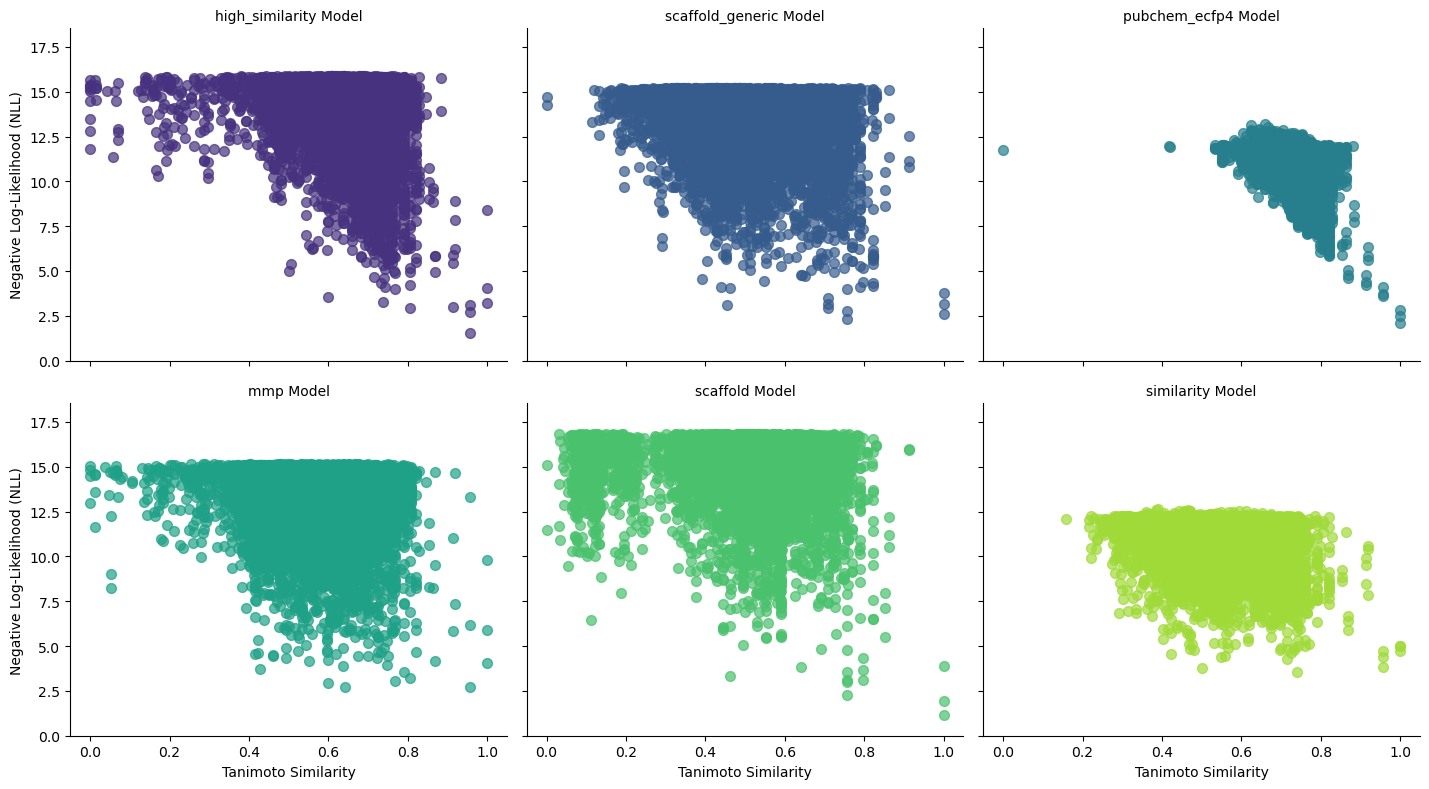

In [69]:
# FutureWarningを無視する設定
warnings.filterwarnings("ignore", category=FutureWarning)

def create_tanimoto_nll_trellis_plot(df):
    """
    TanimotoとNLLのスコアをモデルの値ごとに色分けしたトレリス散布図を作成します。

    Args:
        df (pd.DataFrame): 'Tanimoto', 'NLL', 'model' カラムを含むDataFrame。
    """
    
    # 必要なカラムが存在するか確認
    required_columns = ['Tanimoto', 'NLL', 'model']
    for col in required_columns:
        if col not in df.columns:
            print(f"エラー: 必須カラム '{col}' がDataFrameに存在しません。トレリスプロットを生成できません。")
            return

    # DataFrameが空でないか、または必要なデータが十分に存在するかを確認
    if df.empty or df['Tanimoto'].isnull().all() or df['NLL'].isnull().all():
        print("警告: グラフ描画に必要なデータが不足しているか、全て欠損値です。トレリスプロットを生成できません。")
        return

    print("\n--- トレリスプロット（Tanimoto vs NLL スコア、モデル別） ---")
    
    # FacetGrid を使用してトレリスプロットを作成
    # col='model' で 'model' カラムの値に基づいて各サブプロットが作成されます。
    # col_wrap は1行あたりのサブプロット数です。
    # height は各サブプロットの高さ、aspect はアスペクト比です。
    g = sns.FacetGrid(df, col='model', col_wrap=3, height=4, aspect=1.2, palette='viridis', hue='model')

    # 各サブプロットに散布図を描画
    # plt.scatter を map メソッドに渡します。
    g.map(plt.scatter, 'Tanimoto', 'NLL', alpha=0.7, s=50)

    # タイトルと軸ラベルの設定
    # set_axis_labels は全サブプロットの軸ラベルを設定します。
    # set_titles は各サブプロットのタイトルを設定します。
    g.set_axis_labels('Tanimoto Similarity', 'Negative Log-Likelihood (NLL)')
    g.set_titles(col_template='{col_name} Model') # '{col}' を '{col_name}' に変更    
    # 凡例はFacetGridが自動的に設定してくれることが多いですが、
    # 明示的に追加する場合は add_legend() を使用します。
    # hue を指定しているため、通常は自動で凡例が表示されます。
    # g.add_legend(title='Model') 

    # 必要に応じてY軸の範囲を調整
    g.set(ylim=(0, df['NLL'].max() * 1.1)) # NLLの最大値の1.1倍を上限とする

    plt.tight_layout() # レイアウトを調整して、サブプロットやタイトルが重ならないようにします。
    plt.show() # プロットを表示します。
    
create_tanimoto_nll_trellis_plot(df)

箱ひげ図とバイオリンプロットで比較

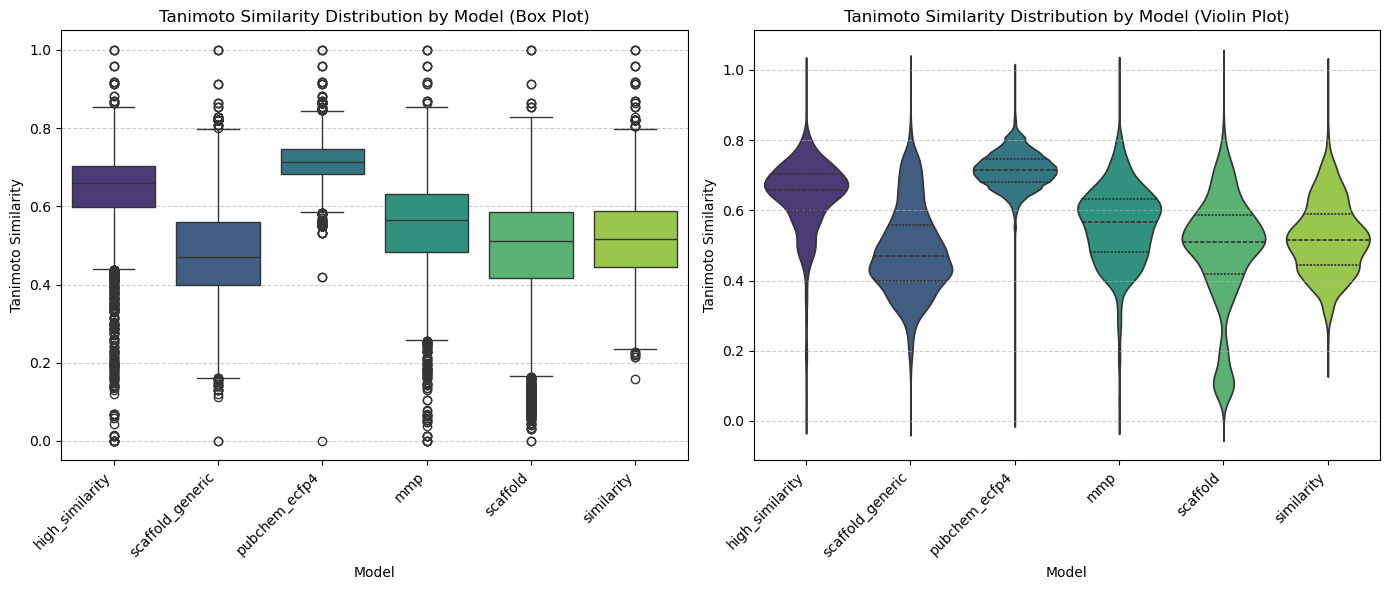

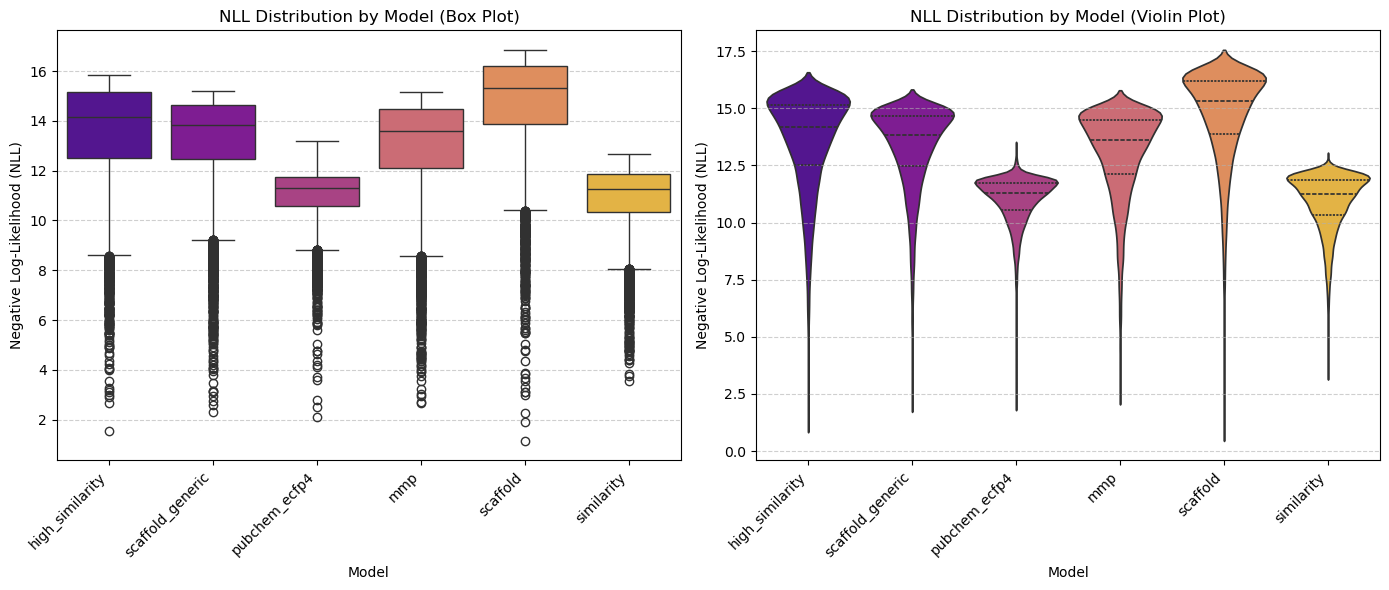

In [71]:
def create_box_violin_plots(df):
    """
    TanimotoとNLLスコアのモデルごとの箱ひげ図とバイオリンプロットを作成します。

    Args:
        df (pd.DataFrame): 'Tanimoto', 'NLL', 'model' カラムを含むDataFrame。
    """
    
    required_columns = ['Tanimoto', 'NLL', 'model']
    for col in required_columns:
        if col not in df.columns:
            print(f"エラー: 必須カラム '{col}' がDataFrameに存在しません。プロットを生成できません。")
            return

    if df.empty or df['Tanimoto'].isnull().all() or df['NLL'].isnull().all():
        print("警告: グラフ描画に必要なデータが不足しているか、全て欠損値です。プロットを生成できません。")
        return

    # Tanimotoスコアの箱ひげ図とバイオリンプロット
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1) # 1行2列の1番目のサブプロット
    sns.boxplot(data=df, x='model', y='Tanimoto', palette='viridis')
    plt.title('Tanimoto Similarity Distribution by Model (Box Plot)')
    plt.xlabel('Model')
    plt.ylabel('Tanimoto Similarity')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2) # 1行2列の2番目のサブプロット
    sns.violinplot(data=df, x='model', y='Tanimoto', palette='viridis', inner="quartile")
    plt.title('Tanimoto Similarity Distribution by Model (Violin Plot)')
    plt.xlabel('Model')
    plt.ylabel('Tanimoto Similarity')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()

    # NLLスコアの箱ひげ図とバイオリンプロット
    plt.figure(figsize=(14, 6))

    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x='model', y='NLL', palette='plasma')
    plt.title('NLL Distribution by Model (Box Plot)')
    plt.xlabel('Model')
    plt.ylabel('Negative Log-Likelihood (NLL)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.subplot(1, 2, 2)
    sns.violinplot(data=df, x='model', y='NLL', palette='plasma', inner="quartile")
    plt.title('NLL Distribution by Model (Violin Plot)')
    plt.xlabel('Model')
    plt.ylabel('Negative Log-Likelihood (NLL)')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

    plt.tight_layout()
    plt.show()
    
create_box_violin_plots(df)


# Scaffold/MMP analysis